In [2]:
import numpy as np
import pandas as pd
import scipy

from sklearn.decomposition import PCA

In [3]:
data = pd.read_csv('hw7_data.csv')
data = data.set_index('date')

In [4]:
data.head()

,gm,adbe,ora,flo,mkt_rf,smb,hml,rf
date,,,,,,,,
2012-10-01,0.120879,0.049014,0.014934,-0.024281,-0.0176,-0.0116,0.0359,0.0001
2012-11-01,0.014902,0.017044,-0.032055,0.195531,0.0078,0.0064,-0.0084,0.0001
2012-12-01,0.113988,0.088703,0.046689,-0.004530,0.0118,0.0150,0.0351,0.0001
2013-01-01,-0.025668,0.003981,0.102697,0.155135,0.0557,0.0033,0.0096,0.0000
2013-02-01,-0.033464,0.039122,-0.038570,0.048363,0.0129,-0.0028,0.0011,0.0000


In [5]:
asset_cols = ['gm', 'adbe', 'ora', 'flo']
factor_cols = ['mkt_rf', 'smb', 'hml']
rf_col = ['rf']

In [6]:
f = data[factor_cols]
r = data[asset_cols]
rfr = data[rf_col]
# subtract rfr from returns based on FFC formula
r_e = r.subtract(rfr.values)
# subtract rfr from returns based on FFC formula
# don't need to do this - data is already excess return
# f['mkt_rf'] = f['mkt_rf'].subtract(rfr.squeeze().values)
x = f.copy(deep=True)
# add col of ones to F
f.loc[:, 'intercept'] = 1
f = f[['intercept'] + factor_cols]

C:\Users\yrevtsov\AppData\Local\Temp\ipykernel_37612\3667321889.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.loc[:, 'intercept'] = 1


In [7]:
b = np.linalg.inv(f.T @ f) @ f.T @ r_e
b.index = f.columns

In [8]:
e = r - f @ b

In [9]:
(f @ b + e - r).abs().sum()

gm      8.673617e-17
adbe    1.008308e-16
ora     8.977194e-17
flo     9.844556e-17
dtype: float64

In [10]:
b

,gm,adbe,ora,flo
intercept,-0.002409,0.008293,0.010312,0.004895
mkt_rf,1.190780,1.201222,0.590398,0.480240
smb,0.729088,-0.253283,0.419412,-0.273027
hml,0.671768,-0.557792,-0.224427,0.256518


### Q 1.1

In [315]:
b

,gm,adbe,ora,flo
intercept,-0.001771,0.008907,0.010622,0.005143
mkt_rf,1.185912,1.199609,0.588666,0.479216
smb,0.728364,-0.255666,0.418711,-0.273790
hml,0.666975,-0.562666,-0.226812,0.254574


### Q 1.2

As seen below, correlations of residual returns are lower than that of excess returns. This aligns with intuition. Parts of returns that correlated should also be explained by the factors of the model. Therefore, the parts that are not explained by the factors are also less correlated.

##### excess return correlation

In [13]:
r_e.corr()

,gm,adbe,ora,flo
gm,1.000000,0.409751,0.379564,0.200341
adbe,0.409751,1.000000,0.163720,0.195851
ora,0.379564,0.163720,1.000000,0.169515
flo,0.200341,0.195851,0.169515,1.000000


##### residual return correlation

In [14]:
e.corr()

,gm,adbe,ora,flo
gm,1.000000,0.130935,0.238876,0.009936
adbe,0.130935,1.000000,-0.141991,0.050953
ora,0.238876,-0.141991,1.000000,0.109304
flo,0.009936,0.050953,0.109304,1.000000


### Q 1.3

In [12]:
sigma = r.cov()

In [13]:
mu = r.mean()

In [350]:
# PCA with 2 components
pca = PCA(n_components=2)
y_sk = pca.fit_transform(r)
y_sk = pd.DataFrame(y_sk)
y_sk.index = r.index

In [328]:
# principal components
gamma = pca.components_

In [346]:
# calculate the residuals
e_pca = r - (y_sk.values @ gamma + mu.values)

##### mean (mu)

In [333]:
mu

gm      0.008983
adbe    0.020731
ora     0.016583
flo     0.009865
dtype: float64

##### gamma (eigenvectors/principal components)

In [348]:
gamma

array([[-0.71899768, -0.42234415, -0.49612657, -0.24192184],
       [-0.17616857, -0.57935232,  0.79101965, -0.08719764]])

##### covariance matrix of error term

In [347]:
e_pca.cov()

,gm,adbe,ora,flo
gm,0.001657,-0.001401,-0.000759,-0.000923
adbe,-0.001401,0.001661,0.000851,-0.000482
ora,-0.000759,0.000851,0.000440,-0.000134
flo,-0.000923,-0.000482,-0.000134,0.003859


### Q 1.4

As seen below, there's a .77 correlation between the first principal component and market return. The scatter plot also shows a linear relationship. Even though principal components do not have direct real-world explanations, this analysis shows that the first principal components can be thought of a market exposure of the assets.

In [373]:
# create df from the first PC and market factor + risk free rate
mkt = y[0].rename('First PC').to_frame().join((f.mkt_rf + rfr.squeeze()).rename('Market'), how='inner')

In [372]:
mkt.corr()

,First PC,Market
First PC,1.000000,0.773348
Market,0.773348,1.000000


<Axes: title={'center': 'First PC vs Market'}, xlabel='First PC', ylabel='Market'>

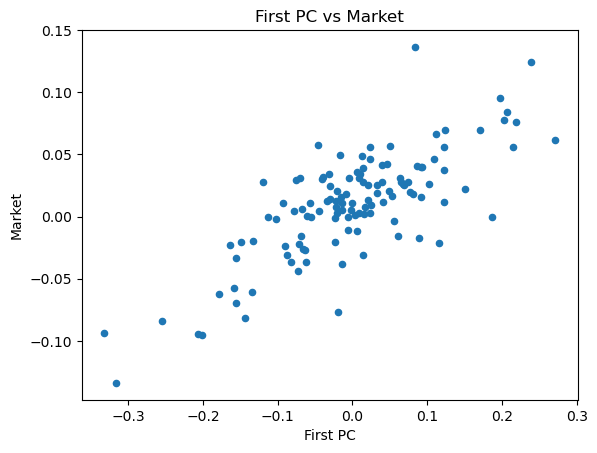

In [371]:
mkt.plot.scatter(x='First PC', y='Market', title='First PC vs Market')

### Q 1.5

Principal components are uncorrelated by definition of the transformation. The residuals are made up of the remaining principal components. Therefore, the residuals will be uncorrelated with other principal components. This is empirically shown below.

In [379]:
e_pca.join(y_sk, how='inner').corr()[[0, 1]].round(10)

,0,1
gm,0.0,0.0
adbe,-0.0,0.0
ora,-0.0,-0.0
flo,-0.0,0.0
0,1.0,-0.0
1,-0.0,1.0


## PCA sklearn

In [296]:
pca.mean_

array([0.00898283, 0.0207307 , 0.01658256, 0.00986473])

In [297]:
pca.explained_variance_ratio_.sum()

0.6884032277509733

## PCA

In [36]:
eigval, eigvec = scipy.linalg.eig(sigma)

In [37]:
eigvec

array([[ 0.71899768,  0.55471646,  0.37986395,  0.17616857],
       [ 0.42234415, -0.69509997, -0.05303146,  0.57935232],
       [ 0.49612657, -0.35359037, -0.05585857, -0.79101965],
       [ 0.24192184,  0.28999919, -0.92183017,  0.08719764]])

In [34]:
y = np.matmul((r - mu), eigvec.T)

gamma = eigvec[:, 0:2]

e_pca = r - (y[[0, 1]] @ gamma.T + mu.values).values

In [35]:
e_pca.cov()

,gm,adbe,ora,flo
gm,0.001402,-0.000420,-0.001406,-0.001692
adbe,-0.000420,0.001125,-0.001365,0.001260
ora,-0.001406,-0.001365,0.004860,0.000133
flo,-0.001692,0.001260,0.000133,0.003050


In [305]:
# first two principal components
f_pca = y_sk.copy()
# intercept
f_cols = ['intercept'] + f_pca.columns.tolist()
f_pca['intercept'] = 1
f_pca = f_pca[f_cols]

In [306]:
mu

gm      0.008983
adbe    0.020731
ora     0.016583
flo     0.009865
dtype: float64

In [307]:
b_pca = np.linalg.inv(f_pca.T @ f_pca) @ f_pca.T @ r
b_pca.index = f_pca.columns

e_pca = r - f_pca @ b_pca

In [308]:
b_pca

,gm,adbe,ora,flo
intercept,0.008983,0.020731,0.016583,0.009865
0,-0.718998,-0.422344,-0.496127,-0.241922
1,-0.176169,-0.579352,0.791020,-0.087198


In [309]:
e_pca.cov()

,gm,adbe,ora,flo
gm,0.001657,-0.001401,-0.000759,-0.000923
adbe,-0.001401,0.001661,0.000851,-0.000482
ora,-0.000759,0.000851,0.000440,-0.000134
flo,-0.000923,-0.000482,-0.000134,0.003859


In [310]:
e_pca.corr()

,gm,adbe,ora,flo
gm,1.000000,-0.844384,-0.888700,-0.364994
adbe,-0.844384,1.000000,0.996034,-0.190583
ora,-0.888700,0.996034,1.000000,-0.102489
flo,-0.364994,-0.190583,-0.102489,1.000000


In [311]:
((f_pca @ b_pca + e_pca) - r).abs().sum()

gm      4.250073e-17
adbe    2.883978e-17
ora     2.710505e-17
flo     5.854692e-17
dtype: float64

In [312]:
eigval

array([0.0117254 +0.j, 0.00341266+0.j, 0.00420309+0.j, 0.00509989+0.j])

In [313]:
y_sk.corr()

,0,1
0,1.000000e+00,-1.055667e-16
1,-1.055667e-16,1.000000e+00


In [314]:
e_pca

,gm,adbe,ora,flo
date,,,,
2012-10-01,0.045925,-0.026851,-0.015755,-0.057305
2012-11-01,-0.020404,-0.044641,-0.017914,0.175313
2012-12-01,0.016066,0.000116,-0.001324,-0.045236
2013-01-01,-0.055084,0.005157,0.006985,0.140385
2013-02-01,-0.021948,0.006563,0.004768,0.043995
...,...,...,...,...
2022-05-01,-0.027255,0.021730,0.011902,0.018656
2022-06-01,0.001038,-0.004445,-0.002046,0.008873
2022-07-01,-0.014458,0.004434,0.003190,0.028689
